In [17]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import   root_mean_squared_error
from xgboost import XGBRegressor

In [18]:
# reset color and other runtime configs
plt.rcParams.update(plt.rcParamsDefault)

%matplotlib inline

# apply a ploting style
plt.style.use("seaborn-v0_8-talk")

In [19]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import root_mean_squared_error
from xgboost import XGBRegressor
import pickle

categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
numerical_features = ["trip_distance", "passenger_count", "hour_of_day"]
target = "duration"


def load_data(filename):
    df = pd.read_parquet(filename)
    df = df[df.passenger_count > 0]

    df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["duration"] = df["duration"].dt.total_seconds() / 60
    df["hour_of_day"] = df.tpep_pickup_datetime.dt.hour
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical_features = ["PULocationID", "DOLocationID", "RatecodeID"]
    numerical_features = ["trip_distance", "passenger_count", "hour_of_day", "duration"]
    df[categorical_features] = df[categorical_features].astype(int).astype(str)
    df = df[categorical_features + numerical_features]

    return df


def train_model():
    df_train = load_data("./data/yellow_tripdata_2024-01.parquet")
    train_dicts = df_train[categorical_features + numerical_features].to_dict(
        orient="records"
    )

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    y_train = df_train[target].values

    model = XGBRegressor(n_estimators=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rmse_train = root_mean_squared_error(y_train, y_pred)

    plot_pred_distribution(
        y=y_train,
        y_pred=y_pred,
        y_label="Actual (Train dataset)",
        y_pred_label="Predicted (Train dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )

    print(f"RMSE: {rmse_train:.2f}")

    return dv, model


def validate_model(dv, model):
    df_val = load_data("./data/yellow_tripdata_2024-02.parquet")
    val_dicts = df_val[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    X_val = dv.transform(val_dicts)
    y_val = df_val[target].values

    y_pred = model.predict(X_val)
    rmse_val = root_mean_squared_error(y_val, y_pred)
    print(f"RMSE: {rmse_val:.2f}")

    plot_pred_distribution(
        y=y_val,
        y_pred=y_pred,
        y_label="Actual (Validation dataset)",
        y_pred_label="Predicted (Validation dataset)",
        x_label="Duration (min)",
        title="Actual vs Predicted Duration Distribution",
    )


def predict(data, model_filename):
    val_dicts = data[categorical_features + numerical_features].to_dict(
        orient="records"
    )
    dv, model = load_model(model_filename)
    X_val = dv.transform(val_dicts)
    y_pred = model.predict(X_val)
    data["predicted_duration"] = y_pred
    return data


def save_model(model, filename):
    path = f"./models/{filename}"
    with open(path, "wb") as f_out:
        pickle.dump(model, f_out)


def load_model(filename):
    path = f"./models/{filename}"
    with open(path, "rb") as f_in:
        return pickle.load(f_in)


def plot_pred_distribution(y, y_pred, y_label, y_pred_label, x_label, title):
    sns.kdeplot(y, label=y_label, fill=True)
    sns.kdeplot(y_pred, label=y_pred_label, fill=True)
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend()
    plt.show()

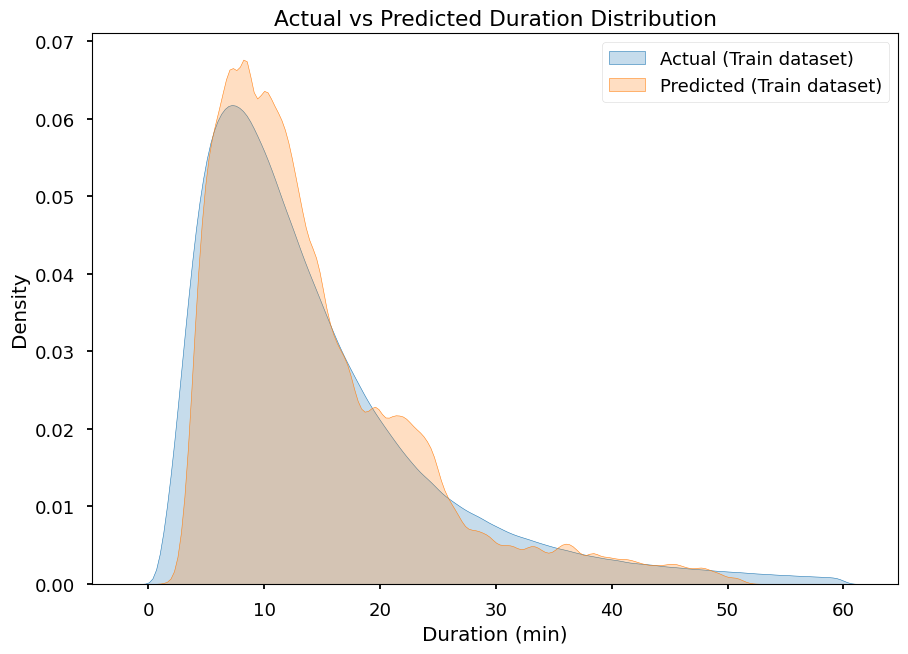

RMSE: 4.50


In [20]:
dv, model = train_model()

RMSE: 4.68


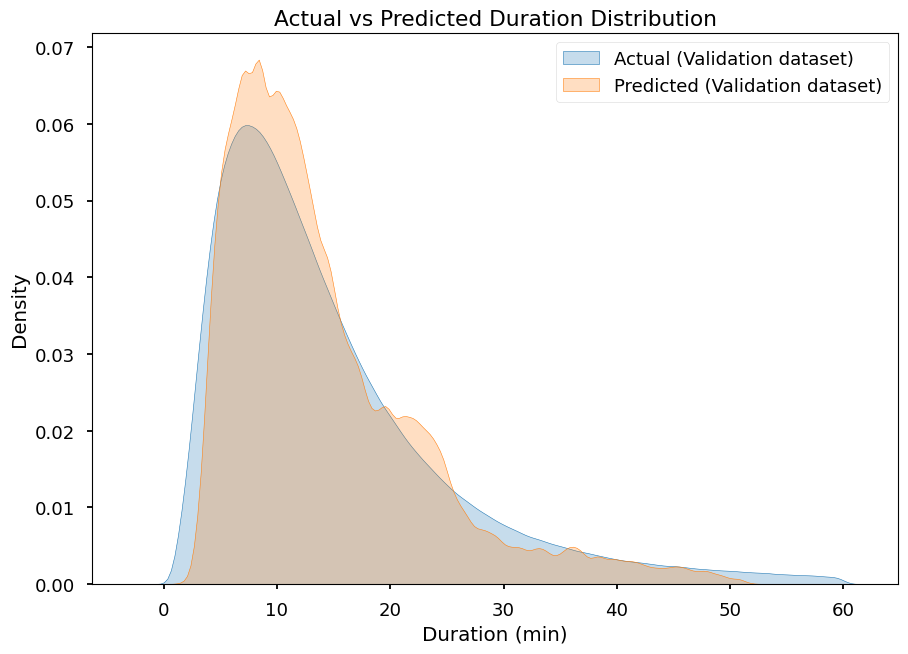

In [21]:
validate_model(dv, model)

In [22]:
filename = "xgb_n_estimators_50.bin"
save_model((dv, model), filename)


In [23]:
data = load_data("./data/yellow_tripdata_2024-02.parquet")
prediction= predict(data[0:6], model_filename="xgb_n_estimators_50.bin")
prediction



/var/folders/hc/75f2v8756lz376jb6_px2_ym0000gn/T/ipykernel_29264/688542204.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["predicted_duration"] = y_pred


,PULocationID,DOLocationID,RatecodeID,trip_distance,passenger_count,hour_of_day,duration,predicted_duration
0,68,236,1,4.39,1.0,0,15.216667,20.579983
1,48,243,1,7.71,1.0,0,14.366667,20.588787
2,132,261,2,28.69,2.0,0,35.366667,39.640770
3,161,163,1,1.10,1.0,0,8.966667,8.425453
4,246,79,1,2.60,1.0,0,13.666667,13.210986
5,79,4,1,0.80,1.0,0,6.600000,5.066521
